<a href="https://colab.research.google.com/github/Svetorus/Data-analysis-algorithms/blob/master/Algoritm_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### Генерация данных

In [0]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=2, random_state=21)

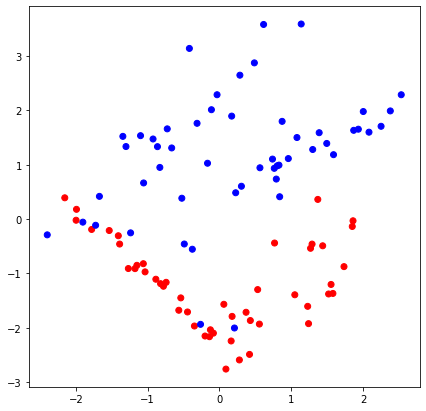

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(7, 7))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

### Реализация леса
Бутстран + Out-of-Bag

In [0]:
def get_bootstrap(data, labels, N=10, random_state=21):
    random.seed(random_state)
    n_samples = data.shape[0]
    bootstrap = []
    oob = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        used_indexes = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            if not sample_index in used_indexes:
                used_indexes.append(sample_index)
        bootstrap.append((b_data, b_labels))
        
        oob_data = np.delete(data, used_indexes, 0)
        oob_labels = np.delete(labels, used_indexes, 0)
        oob.append((oob_data, oob_labels))
        
    return bootstrap, oob

In [0]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [0]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [0]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [0]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

Добавление энтропии Шэннона

In [0]:
# Расчет энтропии Шэннона

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy_score = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p == 0:
            continue
        else:
            entropy_score -= p * np.log2(p)
        
    return entropy_score

In [0]:
# Расчет качества

def quality(left_labels, right_labels, current_criterion, criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if criterion == 'gini':
        return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)
    return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [0]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [0]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    if criterion == 'gini':
        current_criterion = gini(labels)
    else:
        current_criterion = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [0]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criterion):

    quality, t, index = find_best_split(data, labels, criterion)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, criterion)
    false_branch = build_tree(false_data, false_labels, criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Добавление возможности выбора критерия и расчета доли правильных ответов по данным Out-of-Bag

In [0]:
def random_forest(data, labels, n_trees, criterion='gini', oob_score=False):
    forest = []
    bootstrap, oob = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, criterion))
        
    if oob_score:
        oob_scores = []
        for o, tree in zip(oob, forest):
            oob_data, oob_labels = o
            oob_pred = predict(oob_data, tree)
            oob_accuracy = accuracy_metric(oob_labels, oob_pred)
            oob_scores.append(oob_accuracy)
        oob_score_ = np.mean(oob_scores)
        return forest, oob_score_
        
    return forest

In [0]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [0]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [0]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [0]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 21)

In [0]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [0]:
# Визуализируем лес на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def visualize_forest(forest, *data):
    train_data, test_data, train_labels, test_labels = data
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    train_pred = tree_vote(forest, train_data)
    train_accuracy = accuracy_metric(train_labels, train_pred)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    test_pred = tree_vote(forest, test_data)
    test_accuracy = accuracy_metric(test_labels, test_pred)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

    plt.show()

### Визуализация леса

In [0]:
data = train_data, test_data, train_labels, test_labels

1 дерево

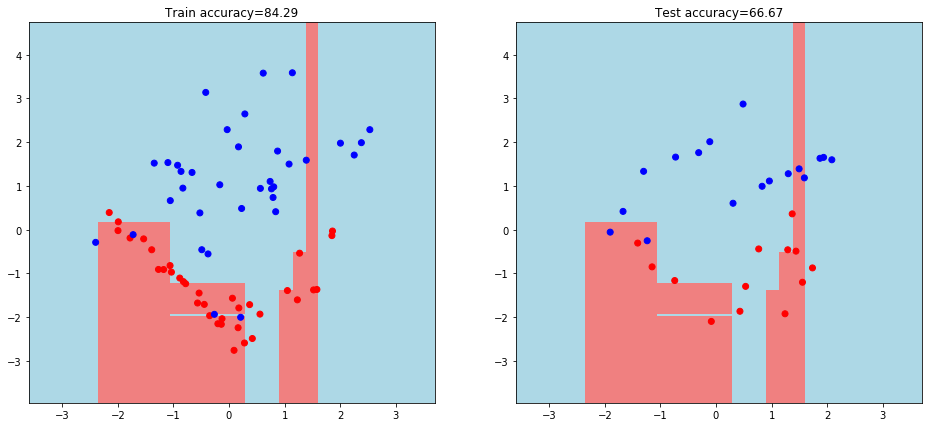

In [22]:
my_forest_1 = random_forest(train_data, train_labels, 1)
visualize_forest(my_forest_1, *data)

3 дерева

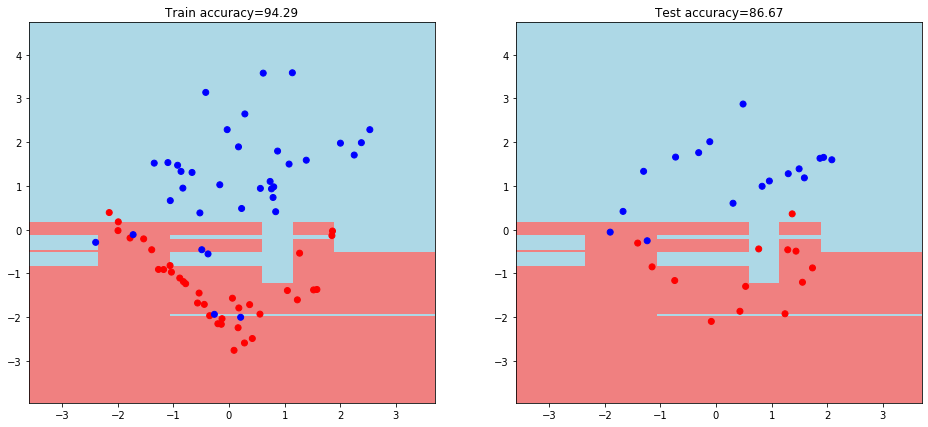

In [23]:
my_forest_3 = random_forest(train_data, train_labels, 3)
visualize_forest(my_forest_3, *data)

10 деревьев

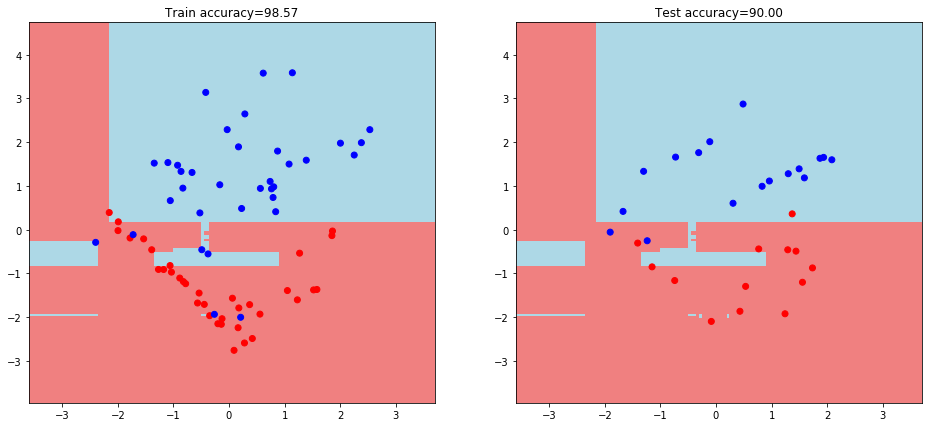

In [24]:
my_forest_10 = random_forest(train_data, train_labels, 10)
visualize_forest(my_forest_10, *data)

50 деревьев

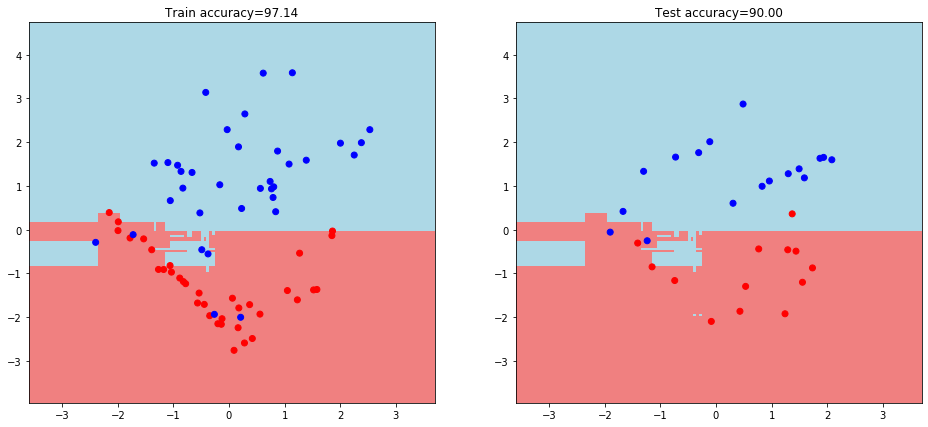

In [25]:
my_forest_50 = random_forest(train_data, train_labels, 50)
visualize_forest(my_forest_50, *data)

**Выводы**: с увеличением количества деревьев в лесе:

общая форма разделяющей гиперплоскости упрощается, стремясь к своему оптимальному варианту;  

ее граница при этом усложняется, получая всё больше "артефактов" от деревьев;
доля правильных ответов на обучающих выборках в целом растет, стремясь к 100% (и иногда достигая их);

на тестовых выборках ее значение всегда получается меньше.